# First steps: a synthetic data study

In this notebook, we'll take a [myokit.Simulation](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html) and wrap it in a [pints.ForwardModel](https://pints.readthedocs.io/en/stable/core_classes_and_methods.html#forward-model).
We'll then use this ForwardModel to generate some data, add synthetic noise, and set up a [pints.SingleOutputProblem](https://pints.readthedocs.io/en/stable/core_classes_and_methods.html#pints.SingleOutputProblem).
Finally, we'll define an [ErrorMeasure](https://pints.readthedocs.io/en/stable/error_measures.html#pints.ErrorMeasure) on this problem and use an [Optimiser](https://pints.readthedocs.io/en/stable/optimisers/index.html) to find the parameter values that minimise it.

The steps we follow here are roughly equal to those followed in the [PINTS examples](https://github.com/pints-team/pints/tree/master/examples), in particular ["Optimisation: First example"](https://github.com/pints-team/pints/blob/master/examples/optimisation/first-example.ipynb).

## Wrapping a simulation in a pints.ForwardModel

To use a simulation in PINTS, we must make it implement the `pints.ForwardModel` interface.
This interface has just two required methods:

- `n_parameters() --> int`.
  This method returns the number of parameters this simulation takes.
- `simulate(parameters, times) --> values`.
  This method performs a simulation with the given model `parameters`, logs at the selected `times`, and returns a list of simulated `values`.

We can repurpose some of our code from the previous examples to write a first ForwardModel implementation.

In [2]:
import myokit
import pints

class Model(pints.ForwardModel):
    """A two-state Hodgkin-Huxley ion current simulation."""
    
    def __init__(self):
        
        # Load model and protocol
        self.model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        self.protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
        
        # Bring model to steady state for -80mV
        a_inf = self.model.get('ikr.act.inf').pyfunc()(-80)
        r_inf = self.model.get('ikr.rec.inf').pyfunc()(-80)
        self.model.get('ikr.act').set_state_value(a_inf)
        self.model.get('ikr.rec').set_state_value(r_inf)

        # Create a simulation
        self.sim = myokit.Simulation(self.model, self.protocol)
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        
        # Reset the simulation
        self.sim.reset()
        
        # Update the parameters
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)
        
        # Run a simulation
        tmax = times[-1] + 0.1
        log = self.sim.run(tmax, log_times=times, log=['ikr.IKr'])
        
        return log['ikr.IKr']
        

Let's try and run a simulation with this model.

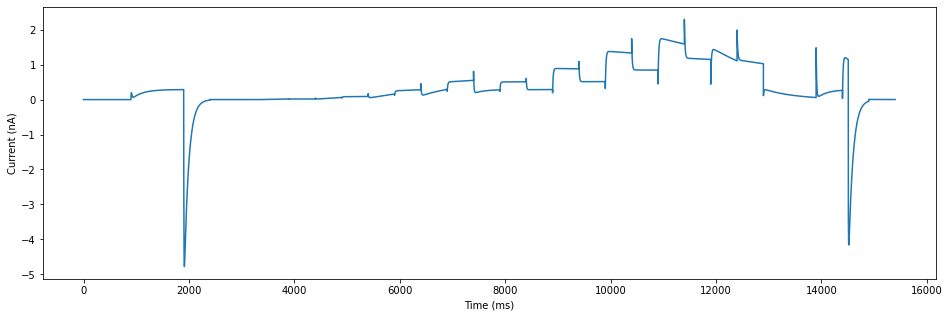

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a model
model = Model()

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Generate the sampling points
t_max = 15400
times = np.arange(0, t_max, 0.1)

# Generate some noise free data
noise_free_values = model.simulate(parameters, times)

# Show the results
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, noise_free_values)
plt.show()

## Adding synthetic noise





Real voltage-clamp experiments are affected by various noise and error sources (see the "Dealing with real data" notebooks for details).
In this example, we'll keep it simple and only add some Gaussian (normally distributed) noise.

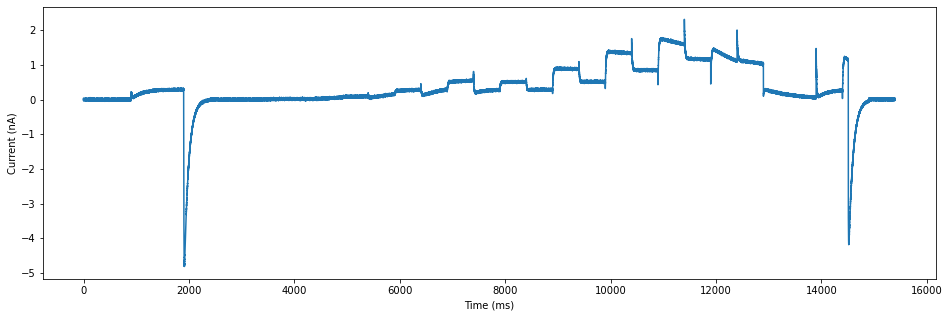

In [4]:
# Add some noise to the data
values = noise_free_values + np.random.normal(0, 0.015, len(noise_free_values))

# Show the results
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values)
plt.show()

## Setting up a pints "Problem"

We now take the times and noisy values (both of which would usually come from experimental data), along with the model, and pack it in a [pints.SingleOutputProblem](https://pints.readthedocs.io/en/stable/core_classes_and_methods.html#pints.SingleOutputProblem).

In [5]:
problem = pints.SingleOutputProblem(model, times, values)

We can now generate new simulation data by just calling ``problem.evaluate(parameters)``.

## Defining an error measure

As the final step in setting up the problem, we define an [error measure](https://pints.readthedocs.io/en/stable/error_measures.html).
For this example, we'll use a [mean-squared error](https://pints.readthedocs.io/en/stable/error_measures.html#pints.MeanSquaredError):

In [6]:
error = pints.MeanSquaredError(problem)

The `error` we've now created acts as a _callable_ (Python's name for anything that can be called like a function).
Its sole input argument is a list of parameters:

In [7]:
# Evaluate the error for the original parameters
error(parameters)

0.00022320155875199792

In [8]:
# Evaluate the error for almost the original parameters
error(parameters * 1.01)

0.0005680791689441888

In [9]:
# Evaluate the error for twice the original parameters
error(parameters * 2)

1.077432904664981

We have now turned our time-series simulation problem into something that acts like a function.
We can apply a numerical optimisation method to try and find the parameters that minimise this function.

### Choosing an error measure

So what's a mean squared error and why are we using it?


The definition of this error is given in [its documentation](https://pints.readthedocs.io/en/stable/error_measures.html#pints.MeanSquaredError) and is fairly straightforward:

$$ E(p) = \frac{1}{N} \sum (z_i - m(t_i|p))^2 $$

where $E(p)$ is the error for parameter vector $p$, $N$ is the total number of sampled time points, $z_i$ is the measurement at sampling point $t_i$, and $m(t_i|p)$ is the simulated value at time $t_i$ using parameter vector $p$.

A practical reason for using this error is that it's one of the simplest functions that does what we need: It takes the error at each time point, and sums over the entire series. 
The square ensures that positive and negative errors don't cancel each other out (alternatively we could have used an `abs()` function).
This makes it one of the simplest errors to apply in any case where we don't know much about the noise.

#### A probabilistic interpretation

If we _do_ know something about the noise, we can get a bit more mathematical.
In this notebook, we created noisy data by taking the original signal and then adding some normally distributed noise.
This would be an appropriate choice if our measurements consisted of some true signal, with a bit of random noise added independently at each time point.
Each measurement $z_i$ would then be a random variable, given by

$$ z_i \sim m(t_i|p) + \mathcal{N}(0, \sigma) = \mathcal{N}(m(t_i|p), \sigma)$$

where $\mathcal{N}(0, \sigma)$ represents a normally distributed random variable with mean 0 and variance $\sigma$.

We can then write a [probability density function](https://en.wikipedia.org/wiki/Normal_distribution) for the probability of measuring a value $z_i$, given that the true parameters are $p$ and the noise level is $\sigma$:

$$ f(z_i|p, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left[ -\frac{\left(z_i - m(t_i|p)\right)^2}{2\sigma^2} \right] $$

The probability density function for measuring the entire signal $D = \{(t_1, z_1), (t_2, z_2), ..., (t_N, z_N)\}$ then becomes

$$ f(D|p, \sigma) = \prod_{i = 1}^{N} \frac{1}{\sigma \sqrt{2\pi}} \exp \left[ -\frac{\left(z_i - m(t_i|p)\right)^2}{2\sigma^2} \right] $$

By definition this is a _likelihood_ 

$$l(p, \sigma|D) \equiv f(D|\sigma, p)$$

We can simplify the equation by rewriting it as a _log-likelihood:_

\begin{align}
\log l(p, \sigma|D) &= \sum_{i = 1}^{N} \log\frac{1}{\sigma \sqrt{2\pi}} + \sum_{i = 1}^{N} \left[ -\frac{\left(z_i - m(t_i|p)\right)^2}{2\sigma^2} \right] \\
&= -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i = 1}^{N} \left(z_i - m(t_i|p)\right)^2
\end{align}

The most likely parameters then, are the ones that _maximise this log-likelihood_.
Since $\pi$ and $\sigma$ are both constants, we can't do anything about the first two terms, so we need to find the $p$ that maximises

$$ -\sum_{i = 1}^{N} \left(z_i - m(t_i|p)\right)^2$$

which brings us back to the "engineering approach" of minimising the sum of squared errors.

We'll revisit this choice of error later in the notebooks on "Dealing with real data".

## Running an optimisation

We're now in a position to run our first optimisation.

To do this, we'll quickly recap the model, problem, and error measure above, and choose a random starting point for the optimisation.

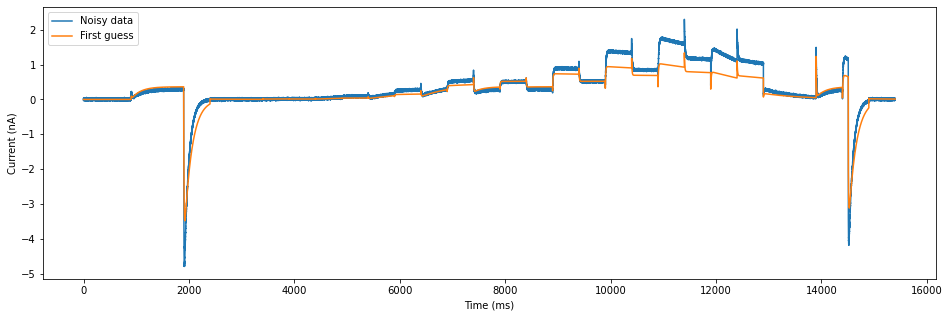

In [10]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints


class Model(pints.ForwardModel):
    """A two-state Hodgkin-Huxley ion current simulation."""
    
    def __init__(self):
        
        # Load model and protocol
        self.model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        self.protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
        
        # Bring model to steady state for -80mV
        a_inf = self.model.get('ikr.act.inf').pyfunc()(-80)
        r_inf = self.model.get('ikr.rec.inf').pyfunc()(-80)
        self.model.get('ikr.act').set_state_value(a_inf)
        self.model.get('ikr.rec').set_state_value(r_inf)

        # Create a simulation
        self.sim = myokit.Simulation(self.model, self.protocol)
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        
        # Reset the simulation
        self.sim.reset()
        
        # Update the parameters
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)
        
        # Run a simulation
        tmax = times[-1] + 1
        log = self.sim.run(tmax, log_times=times, log=['ikr.IKr'])
        
        return log['ikr.IKr']


# Seed numpy's random generator, just to make sure we get the same example every time
np.random.seed(1)
    
# Create a model
model = Model()

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Generate the sampling points
t_max = 15400
times = np.arange(0, t_max, 0.1)

# Generate some noisy data
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.015, len(values))

# Set up a problem, and define an error measure
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Choose a slightly random starting point
x0 = parameters * 2**np.random.normal(0, 0.5, len(parameters))

# Show the intial guess
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(x0), label='First guess')
plt.legend(loc='upper left')
plt.show()

Next we'll create a [pints.OptimisationController](https://pints.readthedocs.io/en/stable/optimisers/running.html) that will run the optimisation for us.
The controller does basic things like checking a stopping criterium and logging output, but can also handle things like parallisation (which is easy on Linux and MacOS, but slightly trickier on Windows).
The actual optimisation is performed by an optimiser implemented in a separate class, and we can use the controller's `method` argument to choose which one.
In this notebook we'll use the [CMA-ES optimisation method](https://pints.readthedocs.io/en/stable/optimisers/cmaes.html), which is known to handle this kind of problem well.

In [11]:
# Create an optimisation controller
opt = pints.OptimisationController(error, x0, method=pints.CMAES)

# Enable parallelisation (multi-processing)
opt.set_parallel(True)

# Run the optimisation
xbest, fbest = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     0.0619     0:00.3
1     20     0.0619     0:00.4
2     30     0.0617     0:00.6
3     40     0.0613     0:00.8
20    210    0.0579     0:03.5
40    410    0.0492     0:06.7
60    610    0.036      0:09.9
80    810    0.0277     0:13.3
100   1010   0.0168     0:16.5
120   1210   0.00506    0:19.8
140   1410   0.00244    0:23.0
160   1610   0.00191    0:26.2
180   1810   0.00151    0:29.3
200   2010   0.00137    0:32.6
220   2210   0.00102    0:35.9
240   2410   0.000794   0:39.5
260   2610   0.000617   0:43.2
280   2810   0.000455   0:46.8
300   3010   0.000386   0:50.0
320   3210   0.000355   0:53.5
340   3410   0.000273   0:57.0
360   3610   0.000226   1:00.3
380   3810   0.000224   1:03.7
400   4010   0.000224   1:07.1
420   4210   0.000224   1:10.4
440   4410   0.000224   1:13.9
460   461

We can inspect the final result by running a simulation with the new parameters:

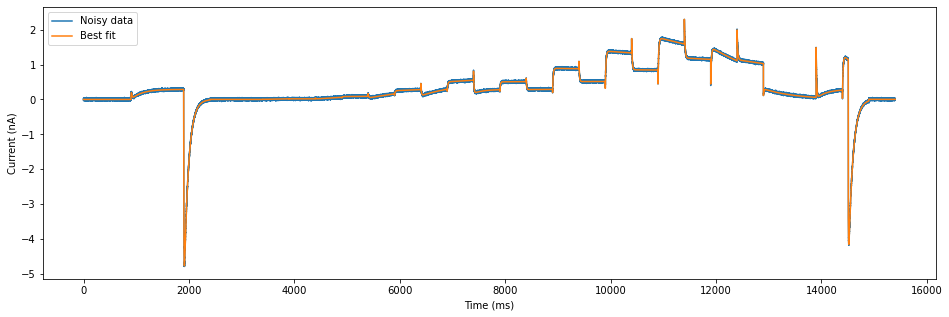

In [12]:
# Show the final result
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values, label='Noisy data')
plt.plot(times, problem.evaluate(xbest), label='Best fit')
plt.legend(loc='upper left')
plt.show()

We can also look at the parameter values themselves.
Because all parameters have different sizes, we scale the obtained solution by the known "true" parameters, and take a 2-log.
In this measure, a value of "1" means "2 times the true parameter value", while "-1" means "half the true parameter value".

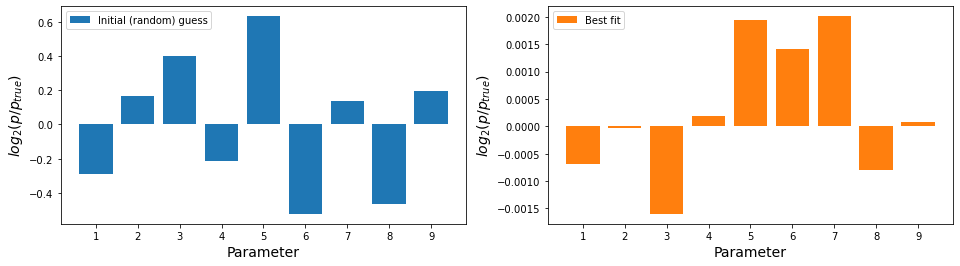

In [13]:
x0_norm = np.log2(x0 / parameters)
xb_norm = np.log2(xbest / parameters)
xticks = np.arange(1, 1 + len(parameters))

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.xlabel('Parameter', fontsize=14)
plt.ylabel('$log_2(p / p_{true})$', fontsize=14)
plt.bar(xticks, x0_norm, label='Initial (random) guess')
plt.xticks(xticks)
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.xlabel('Parameter', fontsize=14)
plt.ylabel('$log_2(p / p_{true})$', fontsize=14)
plt.bar(xticks, xb_norm, label='Best fit', color='tab:orange')
plt.xticks(xticks)
plt.legend(loc='upper left')

plt.show()

Looking at the scale of the y-axis, we can see we've massively improved over the initial estimate.
But the errors are not quite zero either.
So have we really found the parameters that minimise the error?

One way to check this, is to try and draw the optimisation surface near the optimum we found.
The immediate issue here is that the parameter space is 9-dimensional, which is hard to draw.
However, what we _can_ do is take a second point, somewhere near our best esimate, and draw a line between these points.
Regardless of the dimensions of the parameter space, this will be a 1-dimensional line, so we can plot the error measure along that line to get a nice 2-dimensional plot.

If we've really found a minimum, we should see a nice "valley" shape, with our best estimate at its bottom.

What's left to do then is pick a second point and make this plot.
PINTS provides a method [pints.plot.function_between_points](https://pints.readthedocs.io/en/stable/diagnostic_plots.html#pints.plot.function_between_points) that we can use to do the drawing.
And since in this case we know the true solution, we'll use that as the second point.

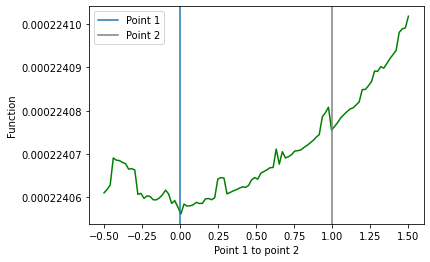

In [15]:
# Import PINTS plotting module
import pints.plot

# Call "function_between_points"
fig, axes = pints.plot.function_between_points(
    error, point_1=xbest, point_2=parameters, padding=0.5, evaluations=100)

plt.show()

This is encouraging, but maybe still a bit unexpected.
Why is the line so craggy?
And does that plot say our best fit (point 1) is _better_ than the true parameters (point 2)?

### Solver tolerance matters for fitting

The jagged nature of the function we plotted above is actually a result of the fact that we've used an _adaptive solver_ to run our simulations.
Like fixed step size solvers such as the forward-Euler method, adaptive solvers use the derivatives at point $x(t)$ during the simulation to make an estimate of $x(t + t_\text{step})$, where $t_\text{step}$ is a very small _step size_.
Adaptive methods do this twice, with two different methods, and then use the difference between these methods to make an estimate of the error they've made.
If this error is above a certain _tolerance,_ the prediction is thrown away and the step size is decreased.
If the error is very small, the step size is slightly increased in the next step.

Now if we change the model parameters, we change the derivatives, and the whole course of the simulation will be different.
For example, we could make all the rates slightly faster, leading to steeper derivatives.
As a result, the solver would need to adjust its step size earlier than before.
This has a knock-on effect on the step size choices in the rest of the simulation, so that the final time points visisted in simulations with similar parameters can vary in a highly sensitive way.
So sensitive in fact, that it can look like the "numerical noise" in the plot above.

This effect was pointed out in [Ross Johnstone's DPhil thesis](http://rossjohnst.one/dphil/), and was also highlighted in [this blog post by Gary Mirams](https://mirams.wordpress.com/2018/10/17/ode-errors-and-optimisation/).

So what can we do about it?
Myokit simulations use the highly-efficient [CVODE](https://computing.llnl.gov/projects/sundials) solver.
This provides two "tolerance" settings, absolute and relative, and we can adjust both from their default settings of (1e-6, 1e-4) to (1e-8, 1e-8) to obtain a much smoother graph -- **and a much easier optimisation problem!**

This is done using [Simulation.set_tolerance()](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#myokit.Simulation.set_tolerance), which we'll incorporate in our "forward model":

In [16]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints


class Model(pints.ForwardModel):
    """A two-state Hodgkin-Huxley ion current simulation."""
    
    def __init__(self):
        
        # Load model and protocol
        self.model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        self.protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
        
        # Bring model to steady state for -80mV
        a_inf = self.model.get('ikr.act.inf').pyfunc()(-80)
        r_inf = self.model.get('ikr.rec.inf').pyfunc()(-80)
        self.model.get('ikr.act').set_state_value(a_inf)
        self.model.get('ikr.rec').set_state_value(r_inf)

        # Create a simulation
        self.sim = myokit.Simulation(self.model, self.protocol)
        
        # Set the solver tolerance
        self.sim.set_tolerance(1e-8, 1e-8)
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        
        # Reset the simulation
        self.sim.reset()
        
        # Update the parameters
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)
        
        # Run a simulation
        tmax = times[-1] + 1
        log = self.sim.run(tmax, log_times=times, log=['ikr.IKr'])
        
        return log['ikr.IKr']


# Seed numpy's random generator, just to make sure we get the same example every time
np.random.seed(1)
    
# Create a model
model = Model()

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Generate the sampling points
t_max = 15400
times = np.arange(0, t_max, 0.1)

# Generate some noisy data
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.015, len(values))

# Set up a problem, and define an error measure
problem = pints.SingleOutputProblem(model, times, values)
error = pints.MeanSquaredError(problem)

# Choose a slightly random starting point
x0 = parameters * 2**np.random.normal(0, 0.5, len(parameters))

# Create an optimisation controller
opt = pints.OptimisationController(error, x0, method=pints.CMAES)

# Enable parallelisation (multi-processing)
opt.set_parallel(True)

# Run the optimisation
xbest, fbest = opt.run()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in parallel with 10 worker processes.
Population size: 10
Iter. Eval. Best      Time m:s
0     10     0.0619     0:00.3
1     20     0.0619     0:00.4
2     30     0.0616     0:00.6
3     40     0.0613     0:00.8
20    210    0.0579     0:03.7
40    410    0.0492     0:07.1
60    610    0.036      0:10.4
80    810    0.0277     0:13.7
100   1010   0.0168     0:17.1
120   1210   0.00506    0:20.3
140   1410   0.00336    0:23.7
160   1610   0.00183    0:27.2
180   1810   0.00161    0:30.9
200   2010   0.00155    0:34.5
220   2210   0.00118    0:37.9
240   2410   0.000922   0:41.4
260   2610   0.000876   0:45.1
280   2810   0.000776   0:48.9
300   3010   0.000469   0:52.4
320   3210   0.000343   0:55.8
340   3410   0.000311   0:59.4
360   3610   0.000239   1:02.9
380   3810   0.000225   1:06.3
400   4010   0.000224   1:10.0
420   4210   0.000224   1:13.5
440   4410   0.000224   1:16.9
460   461

The logs show an interesting effect: even though we've made the simulation problem _harder_ (by setting a lower tolerance), we've made the optimisation problem _easier_ (by creating a smooth optimisation surface).
In this case it seems to have reduced the time it took to run the optimisation a bit, but you'd need repeated runs on a variety of models and data sets to see if this holds true in general.

We can now plot the error function again:

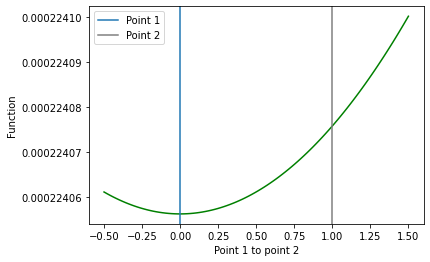

In [18]:
# Import PINTS plotting module
import pints.plot

# Call "function_between_points"
fig, axes = pints.plot.function_between_points(
    error, point_1=xbest, point_2=parameters, padding=0.5, evaluations=100)

plt.show()

Craggyness gone!

But it still seems our recovered parameters are better than the true parameters somehow?

### Noise introduces bias

First, let's just calculate and print the error measure at these numbers:

In [19]:
print('Error at true parameters     : ' + str(error(parameters)))
print('Error at recovered parameters: ' + str(error(xbest)))

Error at true parameters     : 0.00022407574809885084
Error at recovered parameters: 0.00022405622043950905


This confirms what we saw in the plots: The error measure evaluated at the original parameters is very similar to that at our `xbest`, but slightly higher!

This seeming contradiction is a result of fitting to a _finite sample_ of a random distribution.
We can have a look at the effect by subtracting a simulation with the true parameters from our noisy data, and then printing its mean and standard deviation:

In [20]:
generated_noise = values - problem.evaluate(parameters)

print(np.mean(generated_noise))
print(np.std(generated_noise))

5.389221720165219e-05
0.014969062887428056


This matches pretty well with what we specified: the generated sample has a mean of almost zero, and a standard deviation of approximately 0.015 nA.
Note though, that the sample mean isn't quite zero: because we have a finite sample we expect some [standard error](https://en.wikipedia.org/wiki/Standard_error) that will scale approximately with $1/\sqrt{N}$.

We can also print the same numbers using an _estimate_ of the noise signal, by subtracting the simulation at our best parameters:

In [21]:
estimated_noise = values - problem.evaluate(xbest)

print(np.mean(estimated_noise))
print(np.std(estimated_noise))

2.3473162086470636e-05
0.014968489217358267


This shows a very similar standard deviation, but a slightly smaller mean.
In other words, the optimiser has found parameters for which our electrophysiology model removes some of the offset in our noise!

This is an example of "overfitting", where we've made our model fit the data _too well,_ and have arrived at slightly wrong parameter values as a result.
This in turn will result in slightly wrong predictions.
We can check this by comparing a simulation with the true parameters to one made using the recovered parameters:

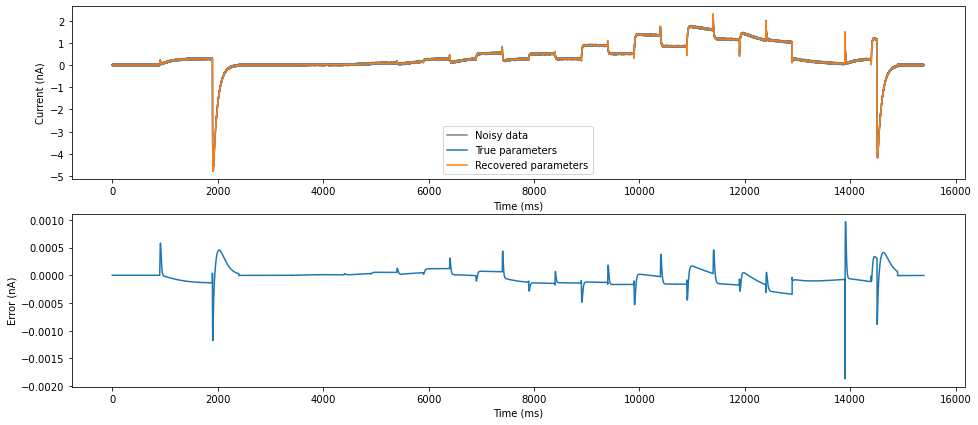

In [22]:
# Show the final result
plt.figure(figsize=(16, 7))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values, color='grey', label='Noisy data')
plt.plot(times, problem.evaluate(parameters), label='True parameters')
plt.plot(times, problem.evaluate(xbest), label='Recovered parameters')
plt.legend(loc='lower center')

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Error (nA)')
plt.plot(times, problem.evaluate(parameters) - problem.evaluate(xbest))

plt.show()

So both graphs match the data really well, but when we compare them we can still see some differences.

Looking back at the graph of the optimisation surface, we can imagine that at some point during the optimisation we passed the correct values and dipped into an area where we started fitting to the noise.
So from a numerics point of view we can now pat ourselves on the back, and say "we've done a great job at fitting: our error is _even lower_ than the true error".
But from a modelling point of view we've learned an uncomfortable truth: that there's a fundamental limit to how much we can learn from fitting to a finite sample of a noisy signal, even in simulation.

## Summary

In this notebook we have

- Set up a PINTS problem and defined an error measure.
- Used an optimisation to find the parameters that minimise this error.
- Seen the benefits of using a fine tolerance when running simulations.
- Seen bias in our estimate of the parameters, caused by our finite sampling of noisy data.

In the next notebook we'll look at some more simulation methods, selecting the appropriate types for different models and protocols.